In [152]:
#import library
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math

import seaborn as sns
import pandas as pd
%matplotlib inline

\begin{equation}
y | \boldsymbol{\theta} \sim \mathcal{N}\left(\mu_{y}, \sigma_{y}^{2}\right), \quad \mu_{y}:=\sum_{k=1}^{\lceil D / 2\rceil} \theta_{2 k-1}+\sum_{k=1}^{\lfloor D / 2\rfloor} \theta_{2 k}^{2}
\end{equation}

\begin{equation}
\theta_{i} \stackrel{\text { iid }}{\sim} \mathcal{N}\left(0, \sigma_{\theta}^{2}\right)
\end{equation}

In [153]:
# define dimentions D

D = np.int(4)

mu= np.zeros(D)

cov = np.eye(D)

when in 4 D
\begin{equation}
\theta_{1}+\theta_{2}^{2}+\theta_{3}+\theta_{4}^{2}
\end{equation}


In [154]:
#define forward function
def f(D,theta):# theta should be vector in D dimentions
    Sum = 0
    for i in range(1,D//2+1):
        Sum += theta[2*i-2]+theta[2*i-1]**2
    
    return tf.convert_to_tensor(Sum, dtype = tf.float32)
theta = [0.1,0,0,0]

f(4,theta)

<tf.Tensor: id=124652730, shape=(), dtype=float32, numpy=0.1>

In [165]:
## initial the model

# generate data
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
Data = tf.convert_to_tensor(y_,dtype = tf.float32)


In [166]:
mu = tf.convert_to_tensor(mu,dtype = tf.float32)
cov = tf.convert_to_tensor(cov,dtype=tf.float32)

In [167]:
## define the log probability
def joint_prob(Data,theta,Dimention):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    # define likelihood
    y = tfd.Normal(loc = f(Dimention,theta), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.prob(theta)
          +tf.reduce_sum(y.prob(Data))))

In [168]:
joint_prob(Data,theta,D)

<tf.Tensor: id=124652981, shape=(), dtype=float32, numpy=1527018800000.0>

In [169]:
x1,x2,x3,x4 = np.mgrid[-2:2:.1, -2:2:.1,-2:2:.1,-2:2:.1]
pos = np.empty(x1.shape + (4,),dtype = np.float32) 
pos[:, :,:,:, 0] = x1;pos[:, :,:,: ,1] = x2;pos[:, :, :,:, 2] = x3;pos[:, :,:,:, 3] = x4

joint_prob(Data,pos[0][0][0][0],D)

<tf.Tensor: id=124653063, shape=(), dtype=float32, numpy=1.5129888>

In [106]:
post = np.empty(x1.shape)
for i1 in range(x1.shape[0]):
    for i2 in range(x1.shape[0]):
        for i3 in range(x1.shape[0]):
            for i4 in range(x1.shape[0]):
                    post[i1][i2][i3][i4] = joint_prob(Data,pos[i1][i2][i3][i4],D)

KeyboardInterrupt: 

In [ ]:
plt.contour(x1, x2, post)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

### HMC

In [170]:
def joint_log_prob(Data,theta,Dimention):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    # define likelihood
    y = tfd.Normal(loc = f(Dimention,theta), scale = sigma2y)
    # return the posterior probability
    return (mvn.prob(theta)
          +tf.reduce_sum(y.prob(Data)))

In [171]:
num_results = 10000
burnin = 1000

initial_chain_state = [
    0. * tf.ones(D, dtype=tf.float32, name="init")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args,D)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.05,
        num_leapfrog_steps = 10),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
x2 = samples[:,1]
x3 = samples[:,2]
x4 = samples[:,3]

x1_accepted = []
x2_accepted =[]
x3_accepted =[]
x4_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [172]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x1_accepted = np.append(x1_accepted,samples[i-1,0])
        x2_accepted = np.append(x2_accepted,samples[i-1,1])
        x3_accepted = np.append(x3_accepted,samples[i-1,2])
        x4_accepted = np.append(x4_accepted,samples[i-1,3])

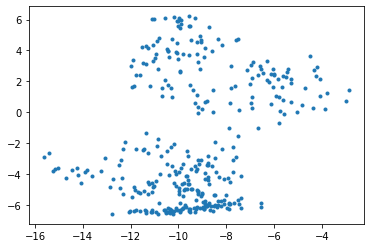

In [173]:
plt.plot(x1_accepted,x2_accepted,'.')

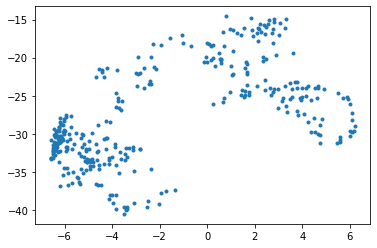

In [174]:
plt.plot(x2_accepted,x3_accepted,'.')

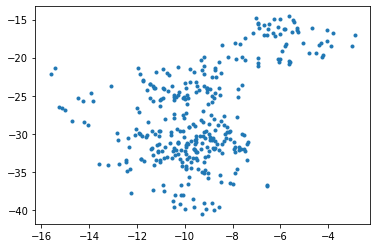

In [175]:
plt.plot(x1_accepted,x3_accepted,'.')

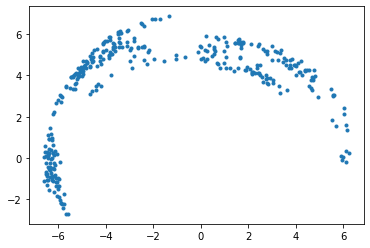

In [176]:
plt.plot(x2_accepted,x4_accepted,'.')